### Trigger PySpark

In [1]:
import os
# os.environ["SPARK_HOME"]
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())
sc

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.1
      /_/

Using Python version 3.6.5 (default, Mar 29 2018 13:14:23)
SparkSession available as 'spark'.


<SparkContext master=local[*] appName=pyspark-shell>

### Library Preparation

In [2]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderEstimator

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pyspark.sql.functions as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
% matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

# sklearn is mainly used to calculate and plot performance metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score


## 1. A Brief Look with Spark

In [3]:
# Load the data to the form of Spark DataFrame
df = spark.read.csv('../data/df_model_final.csv',header=True,inferSchema=True).cache()
df.printSchema()

root
 |-- uid: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- freq_P_last_1: integer (nullable = true)
 |-- freq_P_last_3: integer (nullable = true)
 |-- freq_P_last_7: integer (nullable = true)
 |-- freq_P_last_14: integer (nullable = true)
 |-- freq_P_last_30: integer (nullable = true)
 |-- freq_D_last_1: integer (nullable = true)
 |-- freq_D_last_3: integer (nullable = true)
 |-- freq_D_last_7: integer (nullable = true)
 |-- freq_D_last_14: integer (nullable = true)
 |-- freq_D_last_30: integer (nullable = true)
 |-- freq_S_last_1: integer (nullable = true)
 |-- freq_S_last_3: integer (nullable = true)
 |-- freq_S_last_7: integer (nullable = true)
 |-- freq_S_last_14: integer (nullable = true)
 |-- freq_S_last_30: integer (nullable = true)
 |-- rec_P: integer (nullable = true)
 |-- rec_D: integer (nullable = true)
 |-- rec_S: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- play_time_last_1: double (nullable = true)
 |-- play_time_last

In [4]:
# In order display tidily, choose the first 7 columns
df.select(df.columns[:7]).show(10)

+---------+-----+-------------+-------------+-------------+--------------+--------------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|
+---------+-----+-------------+-------------+-------------+--------------+--------------+
| 34509854|    1|            7|           11|           11|            11|           144|
| 56890349|    0|           41|          141|          220|           509|          1060|
|168552245|    1|            0|            0|            0|             0|           101|
|168553859|    1|            0|            0|            0|             0|           242|
|168556386|    1|            0|            0|            0|             0|             1|
|168556642|    1|            0|            0|            0|             0|             1|
|168577890|    1|            0|            0|            0|             0|             7|
|168590270|    0|            0|           20|           20|            36|           134|
|168605933

In [5]:
df.select(df.columns[2:7]).describe().show()
df.select(df.columns[7:12]).describe().show()
df.select(df.columns[12:17]).describe().show()
df.select(df.columns[17:21]).describe().show()
df.select(df.columns[21:26]).describe().show()
df.select(df.columns[26:31]).describe().show()
df.select(df.columns[31:36]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|     freq_P_last_1|     freq_P_last_3|     freq_P_last_7|   freq_P_last_14|   freq_P_last_30|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|  count|              9765|              9765|              9765|             9765|             9765|
|   mean|3.1378392217101894|10.990168970814132|25.026728110599077|51.65980542754736|154.2995391705069|
| stddev|16.832519796405776|46.045467457212986| 92.81682679963325|174.1722919621382|344.7018543299777|
|    min|                 0|                 0|                 0|                0|                1|
|    max|               498|              1028|              2060|             4151|             7464|
+-------+------------------+------------------+------------------+-----------------+-----------------+

+-------+-------------------+-------------------+-----------------+-----

### Extreme Value Double Check
We only check frequency of playing music for an example. As a matter of factor, the out-lier detection of other types of features has been done in the last feature generation jupyter notebook. Therea re

In [6]:
# frequency of play check: if we assume average length of song is 4min, and we play songs one to the end one 
# one after one, 
# 
print('''The maximum resonable play time (in minutes) per day for last 14 days is {:.2f}. \n
The maximum resonable play time (in minutes) per day for last 30 days is {:.2f}. \n
One day has {} minutes.'''.format(4151/14*4, 7464/30*4, 24*60))

The maximum resonable play time (in minutes) per day for last 14 days is 1186.00. 

The maximum resonable play time (in minutes) per day for last 30 days is 995.20. 

One day has 1440 minutes.


Many features has a lot of missing values, namely zeros. The proportion of 0s of some features is nearly close to 1. Obviously, that's due to how we generate the features.
<font color = red> This phenomenon suggests machine learning algorithms insensitive to missing values.

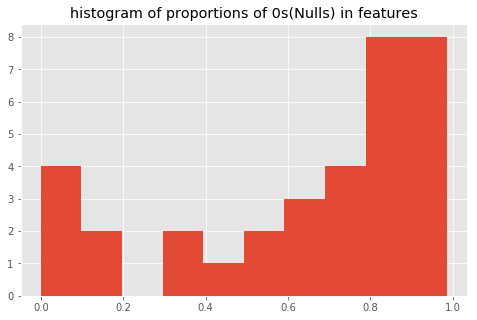

In [7]:
# Convert it to Pandas DataFrame
df_pd = df.toPandas()

# histogram or proportions of nulls in each feature
prop_0s = df_pd[df_pd== 0].count(axis=0)/len(df_pd.index)

plt.figure(figsize=(8,5))
prop_0s.hist()
plt.title('histogram of proportions of 0s(Nulls) in features')
plt.show()

----
---
## 2. Data Preparation and Correlation Plot

### One hot encoder for device type

In [8]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

df_oh = spark.createDataFrame([
    (0, "a"),
    (1, "b"),
    (2, "c"),
    (3, "a"),
    (4, "a"),
    (5, "c")
], ["id", "category"])

stringIndexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
model = stringIndexer.fit(df_oh)
indexed = model.transform(df_oh)

encoder = OneHotEncoder(inputCol="categoryIndex", outputCol="categoryVec")
encoded = encoder.transform(indexed)
encoded.show()

+---+--------+-------------+-------------+
| id|category|categoryIndex|  categoryVec|
+---+--------+-------------+-------------+
|  0|       a|          0.0|(2,[0],[1.0])|
|  1|       b|          2.0|    (2,[],[])|
|  2|       c|          1.0|(2,[1],[1.0])|
|  3|       a|          0.0|(2,[0],[1.0])|
|  4|       a|          0.0|(2,[0],[1.0])|
|  5|       c|          1.0|(2,[1],[1.0])|
+---+--------+-------------+-------------+



In [9]:
df_oh.take(2)

[Row(id=0, category='a'), Row(id=1, category='b')]

### Data Type Casting and Features Preparation

Define a pipeline to convert the type of features.
Please refer to the [databrick](https://docs.databricks.com/spark/latest/mllib/index.html#apache-spark-mllib) and [medium](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa).

In [14]:
stages = []

## One hot encoding the following cat columns
categoricalCols = ['device_type']
for c in categoricalCols:
#     stringIndexer = StringIndexer(inputCol = c, outputCol = c+'_Index')
    onehot_encoder = OneHotEncoderEstimator(inputCols=[c], outputCols=[c+"_onehot"])
    stages += [onehot_encoder]

## convert label type to string type
# Prevent the same column as what Spark MLlib Model ask for, 
# usually in the dataset, the name of response is not 'label'
df = df.withColumnRenamed("label", "churn_label")
labelCol = 'churn_label'
label_stringIdx = StringIndexer(inputCol = labelCol, outputCol = 'label')
stages += [label_stringIdx]

nonNumericCols = categoricalCols+[labelCol]+['uid']
numericCols = [e for e in df.columns if e not in nonNumericCols]

assemblerInputs = [c + "_onehot" for c in categoricalCols] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

colTypeCast_pipeline = Pipeline(stages = stages)
colTypeCast_pipelineModel = colTypeCast_pipeline.fit(df)
data = colTypeCast_pipelineModel.transform(df)
data.printSchema()

## 3. Churn Prediction

### Train Test Split 

In [18]:
# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

In [19]:
## The return of the 'assembler.transform' is 
# 31: number of 'selected_features'
# [0,1,2,3,4,18,19,20,21,22,23,24,25,26,27,28]: position of nonzero features
# [7.0,11.0,11.0,11.0,144.0,4150.0,4622.0,4622.0,4622.0,55245.0,4.0,5.0,5.0,5.0,67.0,0.6363636363636364]: value of these nonzero features
data.select('features').show(1, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|(33,[2,3,4,5,6,20,21,22,23,24,25,26,27,28,29,30],[7.0,11.0,11.0,11.0,144.0,4150.0,4622.0,4622.0,4622.0,55245.0,4.0,5.0,5.0,5.0,67.0,0.6363636363636364])|
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 1 row



### Define Some Functions

In [20]:
#### predict and evaluate performance
# show: if show the top 5 predictions of train and test 
def train_test_model_spark(spark_model, train, test, show=False):
    predictions_train = spark_model.transform(train)
    pred_train = predictions_train.select("probability", "label").toPandas()
    predictions_test = spark_model.transform(test)
    pred_test = predictions_test.select("probability", "label").toPandas()
    if show:
        predictions_train.select("probability","prediction", "label", "features").show(5)
        predictions_test.select("probability","prediction", "label", "features").show(5)
    
    y_train = pred_train['label']
    y_train_pred = np.array([v[1] for v in pred_train['probability']])
    y_test = pred_test['label']
    y_test_pred = np.array([v[1] for v in pred_test['probability']])

    get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred)
    plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)


def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')

    print(all_metrics)

### First Level Model

#### Preset a seed for 'random' model

In [21]:
model_spark_seed = 201

#### logistic regression

In [22]:
lr = LogisticRegression(maxIter=3, regParam=0.01)
lr_model = lr.fit(train)
# # Extract the summary from the returned LogisticRegressionModel instance trained
# # in the earlier example
# trainingSummary = lr_model.summary

# # Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)


# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
# trainingSummary.roc.show()
# trainingSummary.roc.count()
# print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


# # Set the model threshold to maximize F-Measure
# fMeasure = trainingSummary.fMeasureByThreshold
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

              train      test
metrics                      
AUC        0.910026  0.903182
Accuracy   0.841397  0.827975
Precision  0.864620  0.866995
Recall     0.581690  0.555789
f1-score   0.695481  0.677357


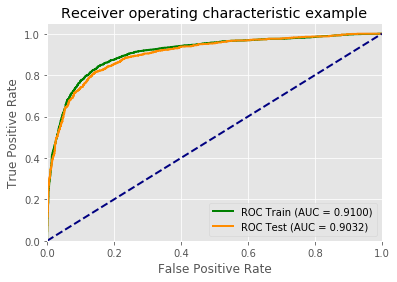

In [23]:
train_test_model_spark(lr_model, train, test)

##### ML Tuning: model selection and hyperparameter tuning

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr_grid = LogisticRegression(maxIter=10)
# pipeline = Pipeline(stages=[lr_grid])

param_lr_grid = ParamGridBuilder() \
    .addGrid(lr_grid.regParam, [10.0, 5.0, 1.0, .5, 0.1, 0.01]) \
    .addGrid(lr_grid.elasticNetParam, [.0, .5, 1.0]) \
    .build()

lr_crossval = CrossValidator(estimator=lr_grid,
                             estimatorParamMaps=param_lr_grid,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)
lr_crossval.setParallelism(8)

# Run cross-validation, and choose the best set of parameters.
lr_cvModel = lr_crossval.fit(train)
lr_cvModel.bestModel

LogisticRegression_4003a1e4834c54c60cdc

In order to show the params of the best model, we have to <font color = red>call the java property</font>.

In [25]:
print('Best Param (regParam): ', lr_cvModel.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', lr_cvModel.bestModel._java_obj.getElasticNetParam())

Best Param (regParam):  0.01
Best Param (elasticNetParam):  0.0


In [26]:
# import numpy as np

# from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
# from pyspark.sql.functions import rand


# class CrossValidatorVerbose(CrossValidator):

#     def _fit(self, dataset):
#         est = self.getOrDefault(self.estimator)
#         epm = self.getOrDefault(self.estimatorParamMaps)
#         numModels = len(epm)

#         eva = self.getOrDefault(self.evaluator)
#         metricName = eva.getMetricName()

#         nFolds = self.getOrDefault(self.numFolds)
#         seed = self.getOrDefault(self.seed)
#         h = 1.0 / nFolds

#         randCol = self.uid + "_rand"
#         df = dataset.select("*", rand(seed).alias(randCol))
#         metrics = [0.0] * numModels

#         for i in range(nFolds):
#             foldNum = i + 1
#             print("Comparing models on fold %d" % foldNum)

#             validateLB = i * h
#             validateUB = (i + 1) * h
#             condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
#             validation = df.filter(condition)
#             train = df.filter(~condition)

#             for j in range(numModels):
#                 paramMap = epm[j]
#                 model = est.fit(train, paramMap)
#                 # TODO: duplicate evaluator to take extra params from input
#                 metric = eva.evaluate(model.transform(validation, paramMap))
#                 metrics[j] += metric

#                 avgSoFar = metrics[j] / foldNum
#                 print("params: %s\t%s: %f\tavg: %f" % (
#                     {param.name: val for (param, val) in paramMap.items()},
#                     metricName, metric, avgSoFar))

#         if eva.isLargerBetter():
#             bestIndex = np.argmax(metrics)
#         else:
#             bestIndex = np.argmin(metrics)

#         bestParams = epm[bestIndex]
#         bestModel = est.fit(dataset, bestParams)
#         avgMetrics = [m / nFolds for m in metrics]
#         bestAvg = avgMetrics[bestIndex]
#         print("Best model:\nparams: %s\t%s: %f" % (
#             {param.name: val for (param, val) in bestParams.items()},
#             metricName, bestAvg))

#         return self._copyValues(CrossValidatorModel(bestModel, avgMetrics))
    
# CrossValidatorVerbose._fit(lr_crossval, train)

In [27]:
## Check the Metrics in 
evaluator = BinaryClassificationEvaluator()
print('The test AUC is: %.6f'%evaluator.evaluate(lr_cvModel.transform(test)))

The test AUC is: 0.908688


              train      test
metrics                      
AUC        0.916472  0.908688
Accuracy   0.864786  0.862175
Precision  0.802005  0.818393
Recall     0.751174  0.740000
f1-score   0.775758  0.777225


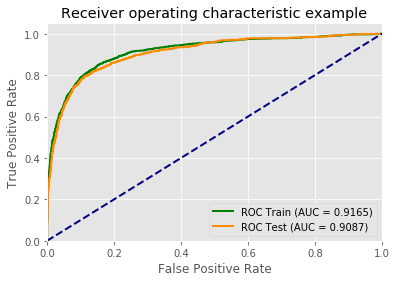

In [28]:
train_test_model_spark(lr_cvModel, train, test)

---
#### Random Forests

In [29]:
rf = RandomForestClassifier(numTrees=50 #50
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=12 #20
                            ,minInstancesPerNode=10
                            ,maxBins=16
                            ,seed=model_spark_seed
                            )
rf_model = rf.fit(train)

In [36]:
rf_model.featureImportances

SparseVector(33, {1: 0.0021, 2: 0.012, 3: 0.0653, 4: 0.0612, 5: 0.0929, 6: 0.0356, 7: 0.0, 8: 0.0003, 9: 0.0009, 10: 0.0037, 11: 0.0112, 12: 0.0001, 13: 0.0005, 14: 0.0043, 15: 0.0166, 16: 0.0154, 17: 0.1707, 18: 0.0104, 19: 0.0122, 20: 0.0023, 21: 0.0592, 22: 0.1142, 23: 0.121, 24: 0.0322, 25: 0.0006, 26: 0.019, 27: 0.0208, 28: 0.0964, 29: 0.0152, 30: 0.0035, 31: 0.0002, 32: 0.0001})

              train      test
metrics                      
AUC        0.944785  0.914806
Accuracy   0.898699  0.858755
Precision  0.875588  0.832714
Recall     0.786385  0.707368
f1-score   0.828593  0.764940


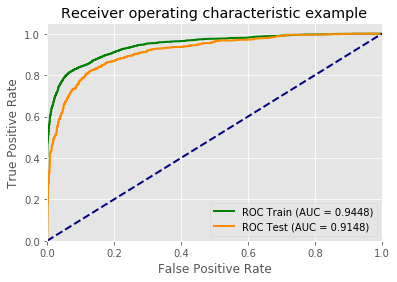

In [30]:
train_test_model_spark(rf_model, train, test)

##### ML Tuning for Random Forests

In [31]:
rf_grid = RandomForestClassifier()
# pipeline = Pipeline(stages=[lr_grid])

param_rf_grid = ParamGridBuilder() \
    .addGrid(rf_grid.numTrees, [50, 100, 150]) \
    .addGrid(rf_grid.featureSubsetStrategy, ['auto']) \
    .addGrid(rf_grid.impurity, ['gini']) \
    .addGrid(rf_grid.maxDepth, [5, 10, 15]) \
    .addGrid(rf_grid.minInstancesPerNode, [2, 8, 14]) \
    .addGrid(rf_grid.maxBins, [16, 32]) \
    .addGrid(rf_grid.seed, [model_spark_seed]) \
    .build()

rf_crossval = CrossValidator(estimator=rf_grid,
                             estimatorParamMaps=param_rf_grid,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)
rf_crossval.setParallelism(8)

# Run cross-validation, and choose the best set of parameters.
rf_cvModel = rf_crossval.fit(train)
rf_cvModel.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_4369a75f46245bf9fef7) with 100 trees

In [32]:
evaluator = BinaryClassificationEvaluator()
print('The CV AUC is: %.6f'%evaluator.evaluate(rf_cvModel.transform(train)))

The CV AUC is: 0.939834


In [33]:
## Print the parameters
rf_param_javaObj = rf_cvModel.bestModel._java_obj
rf_param_javaObj.getNumTrees(), rf_param_javaObj.getFeatureSubsetStrategy(), \
rf_param_javaObj.getImpurity(), rf_param_javaObj.getMaxDepth(), \
rf_param_javaObj.getMinInstancesPerNode(), rf_param_javaObj.getMaxBins()

(100, 'auto', 'gini', 10, 14, 16)

In [34]:
## Check the Metrics in 
evaluator = BinaryClassificationEvaluator()
print('The test AUC is: %.6f'%evaluator.evaluate(rf_cvModel.transform(test)))

The test AUC is: 0.908688


              train      test
metrics                      
AUC        0.939834  0.916519
Accuracy   0.891536  0.861833
Precision  0.862213  0.833741
Recall     0.775587  0.717895
f1-score   0.816609  0.771493


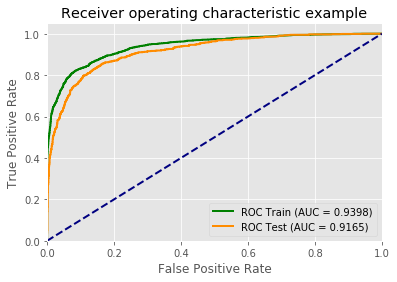

In [35]:
train_test_model_spark(rf_cvModel, train, test)

#### GBDT

In [46]:
gbt = GBTClassifier(maxIter=50
                   ,maxDepth = 5
                   ,maxBins = 16
                   ,seed=model_spark_seed)
gbt_model = rf.fit(train)

In [47]:
gbt_model.featureImportances

SparseVector(33, {1: 0.0135, 2: 0.0292, 3: 0.0192, 4: 0.0391, 5: 0.0414, 6: 0.0731, 7: 0.0031, 8: 0.0029, 9: 0.0124, 10: 0.0226, 11: 0.0657, 12: 0.0032, 13: 0.0165, 14: 0.0241, 15: 0.026, 16: 0.0587, 17: 0.2107, 18: 0.0449, 19: 0.0438, 20: 0.0025, 21: 0.0029, 22: 0.0107, 23: 0.0453, 24: 0.0716, 25: 0.0048, 26: 0.0116, 27: 0.0091, 28: 0.0224, 29: 0.0667, 30: 0.0005, 31: 0.0015, 32: 0.0002})

              train      test
metrics                      
AUC        0.947795  0.910931
Accuracy   0.906739  0.855335
Precision  0.887734  0.821734
Recall     0.801878  0.708421
f1-score   0.842625  0.760882


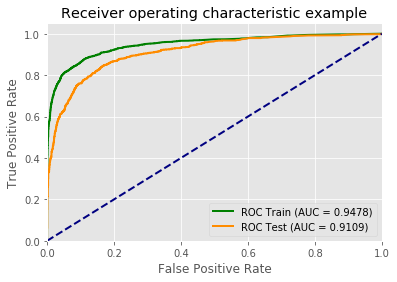

In [48]:
train_test_model_spark(gbt_model, train, test)

##### ML Tuning for Random Forests

In [49]:
gbt_grid = GBTClassifier()
# pipeline = Pipeline(stages=[lr_grid])

param_gbt_grid = ParamGridBuilder() \
    .addGrid(gbt_grid.maxIter, [25, 50, 75]) \
    .addGrid(gbt_grid.maxDepth, [2, 3, 6]) \
    .addGrid(gbt_grid.maxBins, [16, 32, 48]) \
    .addGrid(gbt_grid.seed, [model_spark_seed]) \
    .build()

gbt_crossval = CrossValidator(estimator=gbt_grid,
                             estimatorParamMaps=param_gbt_grid,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)
gbt_crossval.setParallelism(8)

# Run cross-validation, and choose the best set of parameters.
gbt_cvModel = gbt_crossval.fit(train)
gbt_cvModel.bestModel

GBTClassificationModel (uid=GBTClassifier_4cff8c2bdf216b8b2308) with 50 trees

In [50]:
evaluator = BinaryClassificationEvaluator()
print('The CV AUC is: %.6f'%evaluator.evaluate(gbt_cvModel.transform(train)))

The CV AUC is: 0.929206


In [51]:
## Print the parameters
gbt_param_javaObj = gbt_cvModel.bestModel._java_obj
gbt_param_javaObj.getMaxIter(), gbt_param_javaObj.getMaxDepth(), \
gbt_param_javaObj.getMaxBins()

(50, 3, 48)

In [52]:
## Check the Metrics in 
evaluator = BinaryClassificationEvaluator()
print('The test AUC is: %.6f'%evaluator.evaluate(gbt_cvModel.transform(test)))

The test AUC is: 0.909720


              train      test
metrics                      
AUC        0.929206  0.909720
Accuracy   0.879842  0.862859
Precision  0.844211  0.834348
Recall     0.753052  0.721053
f1-score   0.796030  0.773574


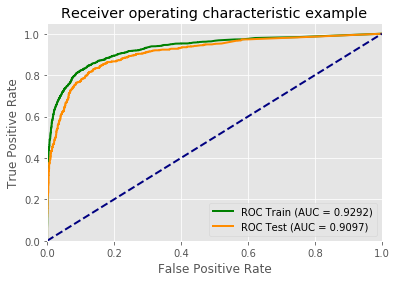

In [53]:
train_test_model_spark(gbt_cvModel, train, test)